- M의 error가 상대적으로 크므로 error plot을 확인해본다

In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import platform
plt.style.use('seaborn')
from datetime import datetime
import json

from metric import E1_loss, E2_loss, total_loss
from models import classifier, cnn_model, conv_block, cnn_parallel
from utils import train_model, eval_model, dfDataset, weights_init

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from sklearn.model_selection import KFold, train_test_split
from torchsummary import summary

In [29]:
SEED = 34
def fix_seed(SEED):
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(SEED)
fix_seed(SEED)

In [7]:
class Noise(object):
    def __init__(self, mu, sd, shape):
        self.mu = mu
        self.sd = sd
        self.shape = shape
    
    def __call__(self, x):
        noise = np.random.normal(self.mu, self.sd, self.shape)
        #noise = torch.FloatTensor(noise)
        return x + noise.astype(np.float32)

class dfDataset(Dataset):
    def __init__(self, x, y, transform = None):
        self.data = x
        self.target = y
        self.transform = transform
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        batchX, batchY = self.data[index], self.target[index]
        if self.transform:
            batchX = self.transform(batchX)
        return batchX, batchY
    
def weights_init(m, initializer = nn.init.kaiming_uniform_):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        initializer(m.weight)
        
def train_model(model, train_data, weight, optimizer, loss_func):
    model.train()
    loss_sum = 0
    for i, (x, y) in enumerate(train_data):
        optimizer.zero_grad()
        x = x.cuda()
        y = y.cuda()
        pred = model(x)
        loss = loss_func(pred, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
    
    return loss_sum / len(train_data)

def eval_model(model, val_data, loss_func):
    model.eval()
    with torch.no_grad():
        loss = 0
        for i, (x, y) in enumerate(val_data):
            x = x.cuda()
            y = y.cuda()
            pred = model(x)
            loss += loss_func(pred, y).item()
    return loss / len(val_data)

class conv_bn(nn.Module):
    def __init__(self, i_f, o_f, fs):
        super(conv_bn, self).__init__()
        self.conv = nn.Conv2d(i_f, o_f, fs)
        self.act = nn.ELU()
        self.bn = nn.BatchNorm2d(o_f)
        self.pool = nn.MaxPool2d(kernel_size=(2, 1), stride= (2, 1))
    def forward(self, x):
        x = self.bn(self.act(self.conv(x)))
        return self.pool(x)
        #return x
    
class conv_block(nn.Module):
    def __init__(self, h_list, input_shape, fs):
        '''
        input_shape : not include batch_size
        '''
        
        super(conv_block, self).__init__()
        self.input_shape = input_shape
        self.fs = fs
        convs = []
        for i in range(len(h_list)):
            if i == 0:
                convs.append(conv_bn(self.input_shape[0], h_list[i], fs))
            else:
                convs.append(conv_bn(h_list[i-1], h_list[i], fs))
        self.convs = nn.Sequential(*convs)
    
    def forward(self, x):
        return self.convs(x)
    
class classifier(nn.Module):
    def __init__(self, h_list, input_size, output_size):
        super(classifier, self).__init__()
        layers = []
        for i in range(len(h_list)):
            if i == 0:
                layers.append(nn.Linear(input_size, h_list[0]))
            else:
                layers.append(nn.Linear(h_list[i-1], h_list[i]))
            layers.append(nn.ELU())
            
        layers.append(nn.Linear(h_list[i], output_size))
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)
    
class cnn_model(nn.Module):
    def __init__(self, cnn_block, fc_block):
        super(cnn_model, self).__init__()
        self.cnn = cnn_block
        self.fc = fc_block
    def forward(self, x):
        x = self.cnn(x)
        x = x.flatten(start_dim = 1)
        return self.fc(x)

def E1_loss(y_pred, y_true):
    _t, _p = y_true, y_pred
    
    return torch.mean(torch.mean((_t - _p) ** 2, axis = 1)) / 2e+04

def E2_loss(y_pred, y_true):
    _t, _p = y_true, y_pred
    
    return torch.mean(torch.mean((_t - _p) ** 2 / (_t + 1e-06), axis = 1))

### Configuration

In [17]:
EPOCH = 100
base_lr = 0.001
now = datetime.strftime(datetime.now(), '%Y%m%d-%H%M%S')
save_path = './model/{}'.format(now)
initialize = True
print_summary = True
batch_size = 256
nfold = 10

### load dataset

In [30]:
def normalize(x, axis = 2):
    mu = np.expand_dims(x.mean(axis = 2), axis = axis)
    sd = np.expand_dims(x.std(axis = 2), axis = axis)

    normalized = (x - mu) / sd
    return normalized

In [35]:
if platform.system() == 'Windows':
    root_dir = 'D:/datasets/KAERI_dataset/'
else:
    root_dir = '/home/bskim/project/kaeri/KAERI_dataset/'

train_f = pd.read_csv(os.path.join(root_dir, 'train_features.csv'))
train_t = pd.read_csv(os.path.join(root_dir, 'train_target.csv'))
test_f = pd.read_csv(os.path.join(root_dir, 'test_features.csv'))

train_f = train_f[['Time','S1','S2','S3','S4']].values
train_f = train_f.reshape((-1, 1, 375, 5))#.astype(np.float32)

test_f = test_f[['Time','S1','S2','S3','S4']].values
test_f = test_f.reshape((-1, 1, 375, 5))#.astype(np.float32)

# concatenate normalized data
train_norm = normalize(train_f)
test_norm = normalize(test_f)

train_f = np.concatenate((train_f, train_norm), axis = 1)
test_f = np.concatenate((test_f, test_norm), axis = 1)

test_f = torch.FloatTensor(test_f)

In [36]:
def kfold_train(name, feature, target):
    print('{} train...'.format(name))
    n_features = feature.shape[-1]
    os.makedirs(save_path) if not os.path.exists(save_path) else None
    # make dataset
    train_target = target[list(name)].values

    fold = KFold(nfold, shuffle = True, random_state= 25)
    loss_per_cv = []
    noise_add = Noise(0, 0.02, feature.shape[1:])
    predict_arr = np.zeros((2800,1))
    for i, (train_idx, val_idx) in enumerate(fold.split(feature, y = train_target)):
        print('fold {}'.format(i+1))
        trainx = feature[train_idx]
        valx = feature[val_idx]
        trainy = train_target[train_idx]
        valy = train_target[val_idx]

        train_dataset = dfDataset(trainx.astype(np.float32), trainy, transform = noise_add)
        train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
        val_dataset = dfDataset(valx.astype(np.float32), valy)
        val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)

        conv = conv_block([16, 32, 64, 128, 256, 512], [2, 375, n_features], (4, 1))
        fc = classifier([128, 64, 32, 16], input_size = 512*1*n_features, output_size = len(name))
        # define model
        model = cnn_model(conv, fc)
        #model = get_model()
        optimizer = torch.optim.Adam(model.parameters(), lr = base_lr)

        if name == 'XY':
            criterion = E1_loss
        else:
            criterion = E2_loss

        model = model.cuda()
        if initialize:
            model.apply(weights_init)

        curr_loss = 1e+7
        #train
        for ep in range(1, EPOCH + 1):
            loss = train_model(model, train_loader, criterion, optimizer, criterion)
            val_loss = eval_model(model, val_loader, criterion)
            if curr_loss > val_loss:
                print('[{}] : train loss {:4f}, val loss drop {:.4f} to {:.4f}'.format(ep, np.mean(loss), curr_loss, val_loss))
                curr_loss = val_loss
                torch.save(model.state_dict(), os.path.join(save_path, 'model_{}_fold{}.pt'.format(name, i+1)))
        model.load_state_dict(torch.load(os.path.join(save_path, 'model_{}_fold{}.pt'.format(name, i+1))))
        pred = model(torch.FloatTensor(valx).cuda())
        predict_arr[val_idx,:] = pred.detach().cpu().numpy()
        loss_per_cv.append(curr_loss)
    return predict_arr

In [37]:
add_feature = train_t[['X','Y','V']].values.reshape((2800, 1, 1, 3))
add_feature = np.repeat(add_feature, 375, axis = 2)
add_feature = np.repeat(add_feature, 2, axis = 1)
trainX = np.concatenate((train_f, add_feature), axis = -1)

In [38]:
# train V using XY
predict = kfold_train('M',trainX, train_t)

M train...
fold 1
[1] : train loss 52.170004, val loss drop 10000000.0000 to 21.9465
[2] : train loss 6.389566, val loss drop 21.9465 to 11.2383
[3] : train loss 1.645677, val loss drop 11.2383 to 7.4174
[4] : train loss 0.789743, val loss drop 7.4174 to 4.5769
[5] : train loss 0.843542, val loss drop 4.5769 to 2.1124
[7] : train loss 0.340595, val loss drop 2.1124 to 0.2565
[8] : train loss 0.246729, val loss drop 0.2565 to 0.1831
[13] : train loss 0.313766, val loss drop 0.1831 to 0.0954
[21] : train loss 0.379251, val loss drop 0.0954 to 0.0582
[28] : train loss 0.166976, val loss drop 0.0582 to 0.0371
[57] : train loss 0.067954, val loss drop 0.0371 to 0.0167
[69] : train loss 0.065715, val loss drop 0.0167 to 0.0123
fold 2
[1] : train loss 38.505837, val loss drop 10000000.0000 to 7.7397
[4] : train loss 0.809252, val loss drop 7.7397 to 1.3772
[5] : train loss 0.524615, val loss drop 1.3772 to 0.5727
[6] : train loss 0.368703, val loss drop 0.5727 to 0.2385
[10] : train loss 0.27

In [41]:
target = train_t['M'].values

In [53]:
res = (target - predict[:,0]) / (target + 1e-6)

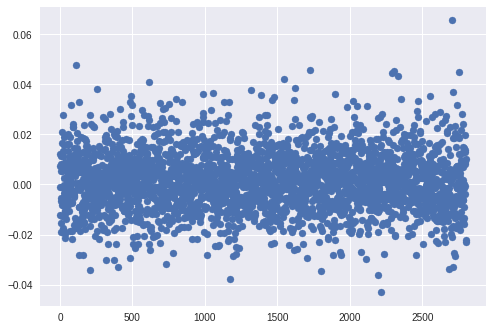

In [54]:
plt.scatter(range(len(res)), res)